# Bilingual Hotel Menu Display System

## Project Overview

This notebook implements a complete pipeline for translating hotel menu items from English to Kannada and Hindi using pretrained transformer models. The system includes:

- **Dataset Analysis**: Comprehensive analysis of 500 menu items across 3 languages
- **Model Training**: Fine-tuning pretrained seq2seq models for translation
- **Evaluation**: BLEU score metrics and validation
- **OCR Integration**: Extract text from menu images
- **Interactive UI**: Streamlit/Gradio interface for real-world usage

---

## 1. Import Required Libraries

In [1]:
# Data Processing
import pandas as pd
import numpy as np
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & NLP
import torch
from transformers import (
    MarianMTModel, MarianTokenizer,
    MBartForConditionalGeneration, MBart50TokenizerFast,
    Trainer, TrainingArguments,
    DataCollatorForSeq2Seq
)
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Evaluation Metrics
from sacrebleu import corpus_bleu
import evaluate

# Utilities
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ All libraries imported successfully!")
print(f"Using PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All libraries imported successfully!
Using PyTorch version: 2.8.0+cpu
CUDA available: False


## 2. Dataset Loading & Initial Analysis

In [2]:
# Load the menu dataset
df = pd.read_csv('menu_dataset.csv')

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\n" + "="*50)
print("First 5 rows:")
print("="*50)
df.head()

Dataset loaded successfully!

Dataset shape: (500, 4)
Columns: ['item_id', 'english_name', 'kannada_name', 'hindi_name']

First 5 rows:


,item_id,english_name,kannada_name,hindi_name
0,1,Idli,ಇಡ್ಲಿ,इडली
1,2,Masala Dosa,ಮಸಾಲೆ ದೋಸೆ,मसाला डोसा
2,3,Plain Dosa,ಪ್ಲೇನ್ ದೋಸೆ,सादा डोसा
3,4,Rava Dosa,ರವಾ ದೋಸೆ,रवा डोसा
4,5,Vada,ವಡೆ,वड़ा


In [3]:
# Basic statistics
print("Dataset Information:")
print("="*50)
print(f"Total records: {len(df)}")
print(f"\nUnique English items: {df['english_name'].nunique()}")
print(f"Unique Kannada items: {df['kannada_name'].nunique()}")
print(f"Unique Hindi items: {df['hindi_name'].nunique()}")

print("\n" + "="*50)
print("Missing Values:")
print("="*50)
print(df.isnull().sum())

print("\n" + "="*50)
print("Data Types:")
print("="*50)
print(df.dtypes)

Dataset Information:
Total records: 500

Unique English items: 127
Unique Kannada items: 126
Unique Hindi items: 126

Missing Values:
item_id         0
english_name    0
kannada_name    0
hindi_name      0
dtype: int64

Data Types:
item_id          int64
english_name    object
kannada_name    object
hindi_name      object
dtype: object


## 3. Data Visualization & Analytics

In [4]:
# Category extraction function
def extract_category(item_name):
    """Extract food category from item name"""
    item_lower = item_name.lower()
    
    # Define category keywords
    categories = {
        'Paneer': ['paneer'],
        'Chicken': ['chicken'],
        'Mutton': ['mutton'],
        'Fish': ['fish'],
        'Prawn': ['prawn'],
        'Egg': ['egg'],
        'Rice': ['rice', 'biryani'],
        'Dosa': ['dosa'],
        'Dal': ['dal'],
        'Bread': ['naan', 'roti', 'paratha', 'poori'],
        'Dessert': ['gulab', 'rasgulla', 'kheer', 'jalebi', 'ladoo', 'halwa'],
        'Beverage': ['chai', 'coffee', 'lassi', 'lemonade', 'buttermilk'],
        'Snacks': ['pakora', 'samosa', 'tikki', 'tikka'],
        'Vegetable': ['veg', 'mushroom', 'aloo', 'gobhi', 'bhindi', 'palak', 'chole', 'rajma', 'kofta']
    }
    
    for category, keywords in categories.items():
        if any(keyword in item_lower for keyword in keywords):
            return category
    
    return 'Other'

# Add category column
df['category'] = df['english_name'].apply(extract_category)

print("Categories extracted successfully!")
print(f"\nCategory distribution:")
print(df['category'].value_counts())

Categories extracted successfully!

Category distribution:
category
Paneer       147
Vegetable    127
Chicken       49
Dal           37
Other         37
Rice          21
Mutton        19
Fish          14
Snacks        11
Prawn         10
Bread          6
Beverage       6
Dessert        6
Dosa           5
Egg            5
Name: count, dtype: int64


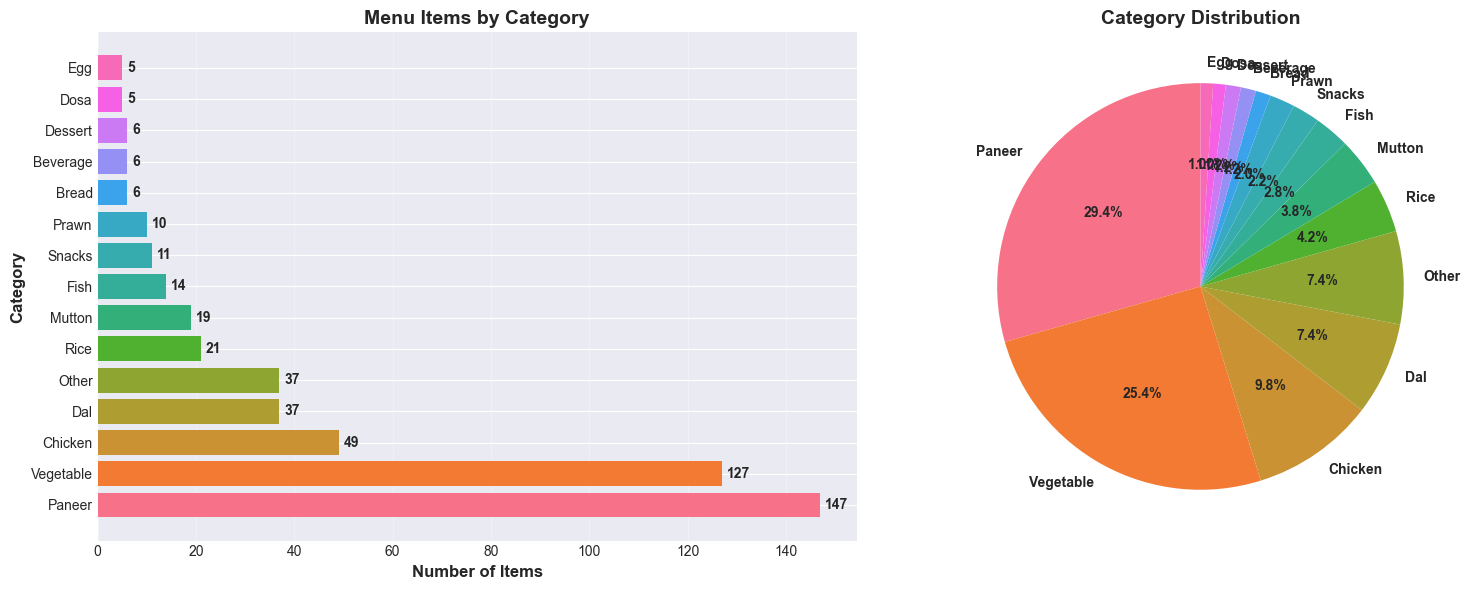


📊 Total categories: 15
📊 Most common category: Paneer (147 items)


In [5]:
# Visualization 1: Category Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
category_counts = df['category'].value_counts()
axes[0].barh(category_counts.index, category_counts.values, color=sns.color_palette('husl', len(category_counts)))
axes[0].set_xlabel('Number of Items', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Category', fontsize=12, fontweight='bold')
axes[0].set_title('Menu Items by Category', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(category_counts.values):
    axes[0].text(v + 1, i, str(v), va='center', fontweight='bold')

# Pie chart
colors = sns.color_palette('husl', len(category_counts))
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[1].set_title('Category Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Total categories: {len(category_counts)}")
print(f"📊 Most common category: {category_counts.index[0]} ({category_counts.values[0]} items)")

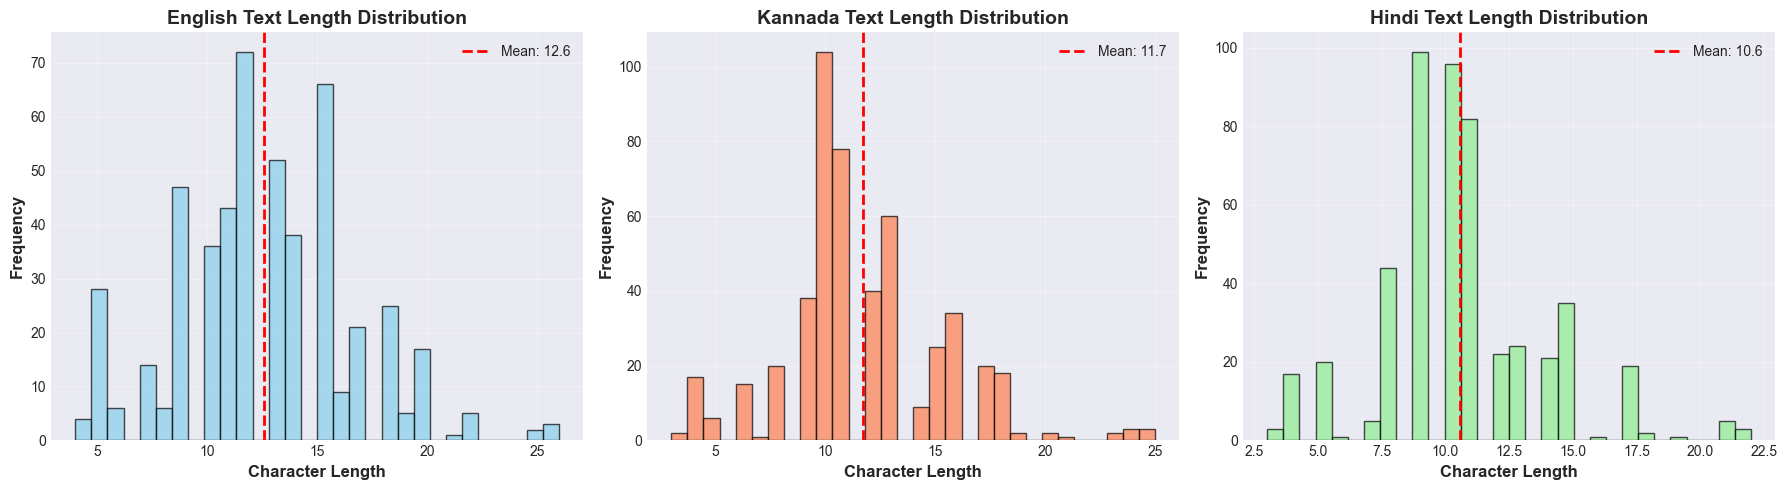


Text Length Statistics:
English - Mean: 12.60, Max: 26, Min: 4
Kannada - Mean: 11.72, Max: 25, Min: 3
Hindi   - Mean: 10.57, Max: 22, Min: 3


In [6]:
# Visualization 2: Text Length Analysis
df['english_length'] = df['english_name'].str.len()
df['kannada_length'] = df['kannada_name'].str.len()
df['hindi_length'] = df['hindi_name'].str.len()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# English
axes[0].hist(df['english_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Character Length', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('English Text Length Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(df['english_length'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['english_length'].mean():.1f}")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Kannada
axes[1].hist(df['kannada_length'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Character Length', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Kannada Text Length Distribution', fontsize=14, fontweight='bold')
axes[1].axvline(df['kannada_length'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['kannada_length'].mean():.1f}")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Hindi
axes[2].hist(df['hindi_length'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Character Length', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[2].set_title('Hindi Text Length Distribution', fontsize=14, fontweight='bold')
axes[2].axvline(df['hindi_length'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['hindi_length'].mean():.1f}")
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nText Length Statistics:")
print("="*50)
print(f"English - Mean: {df['english_length'].mean():.2f}, Max: {df['english_length'].max()}, Min: {df['english_length'].min()}")
print(f"Kannada - Mean: {df['kannada_length'].mean():.2f}, Max: {df['kannada_length'].max()}, Min: {df['kannada_length'].min()}")
print(f"Hindi   - Mean: {df['hindi_length'].mean():.2f}, Max: {df['hindi_length'].max()}, Min: {df['hindi_length'].min()}")

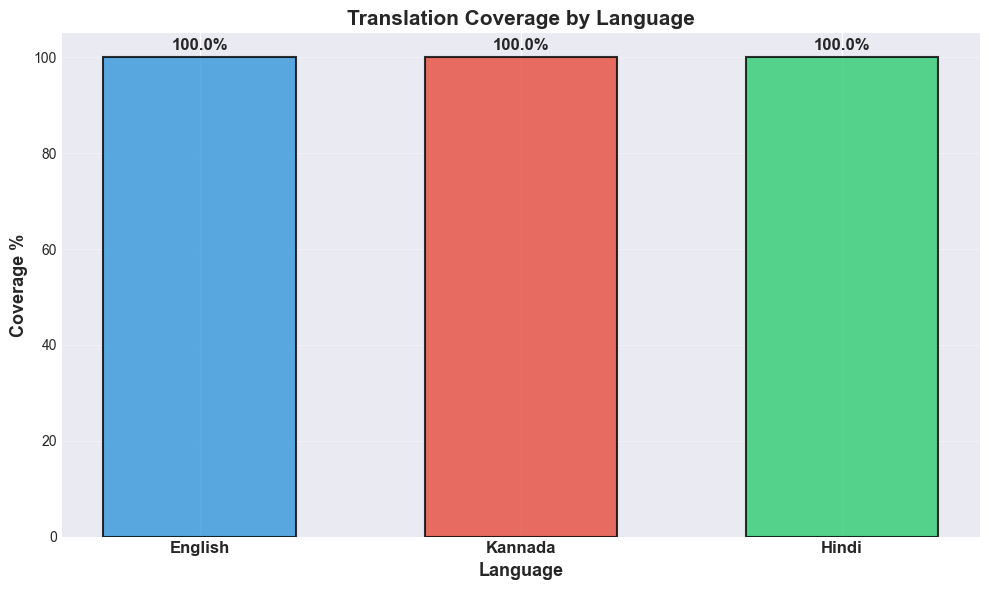


Translation Coverage Summary:
Language  Total Items  Non-Null  Coverage %
 English          500       500       100.0
 Kannada          500       500       100.0
   Hindi          500       500       100.0


In [7]:
# Visualization 3: Translation Coverage Stats
coverage_stats = {
    'Language': ['English', 'Kannada', 'Hindi'],
    'Total Items': [len(df), len(df), len(df)],
    'Non-Null': [df['english_name'].notna().sum(), df['kannada_name'].notna().sum(), df['hindi_name'].notna().sum()],
    'Coverage %': [
        (df['english_name'].notna().sum() / len(df)) * 100,
        (df['kannada_name'].notna().sum() / len(df)) * 100,
        (df['hindi_name'].notna().sum() / len(df)) * 100
    ]
}

coverage_df = pd.DataFrame(coverage_stats)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(coverage_df))
width = 0.6

bars = ax.bar(x, coverage_df['Coverage %'], width, color=['#3498db', '#e74c3c', '#2ecc71'], 
               edgecolor='black', linewidth=1.5, alpha=0.8)

ax.set_xlabel('Language', fontsize=13, fontweight='bold')
ax.set_ylabel('Coverage %', fontsize=13, fontweight='bold')
ax.set_title('Translation Coverage by Language', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(coverage_df['Language'], fontsize=12, fontweight='bold')
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nTranslation Coverage Summary:")
print(coverage_df.to_string(index=False))

## 4. Data Preprocessing

In [8]:
# Handle missing values
print("Checking for missing values...")
print(df.isnull().sum())

# Remove rows with missing translations (if any)
df_clean = df.dropna(subset=['english_name', 'kannada_name', 'hindi_name']).copy()

print(f"\nOriginal dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_clean)}")
print(f"Rows removed: {len(df) - len(df_clean)}")

# Create separate datasets for each translation pair
# English -> Kannada
en_kn_data = df_clean[['english_name', 'kannada_name']].copy()
en_kn_data.columns = ['source', 'target']

# English -> Hindi
en_hi_data = df_clean[['english_name', 'hindi_name']].copy()
en_hi_data.columns = ['source', 'target']

print("\n✅ Data preprocessing completed!")
print(f"English → Kannada pairs: {len(en_kn_data)}")
print(f"English → Hindi pairs: {len(en_hi_data)}")

Checking for missing values...
item_id           0
english_name      0
kannada_name      0
hindi_name        0
category          0
english_length    0
kannada_length    0
hindi_length      0
dtype: int64

Original dataset size: 500
Cleaned dataset size: 500
Rows removed: 0

✅ Data preprocessing completed!
English → Kannada pairs: 500
English → Hindi pairs: 500


In [9]:
# Train-Validation Split (80-20)
train_kn, val_kn = train_test_split(en_kn_data, test_size=0.2, random_state=42)
train_hi, val_hi = train_test_split(en_hi_data, test_size=0.2, random_state=42)

print("Dataset Split Summary:")
print("="*50)
print("\nEnglish → Kannada:")
print(f"  Training set: {len(train_kn)} samples ({len(train_kn)/len(en_kn_data)*100:.1f}%)")
print(f"  Validation set: {len(val_kn)} samples ({len(val_kn)/len(en_kn_data)*100:.1f}%)")

print("\nEnglish → Hindi:")
print(f"  Training set: {len(train_hi)} samples ({len(train_hi)/len(en_hi_data)*100:.1f}%)")
print(f"  Validation set: {len(val_hi)} samples ({len(val_hi)/len(en_hi_data)*100:.1f}%)")

# Display sample data
print("\n" + "="*50)
print("Sample Training Data (English → Kannada):")
print("="*50)
print(train_kn.head(3).to_string(index=False))

print("\n" + "="*50)
print("Sample Training Data (English → Hindi):")
print("="*50)
print(train_hi.head(3).to_string(index=False))

Dataset Split Summary:

English → Kannada:
  Training set: 400 samples (80.0%)
  Validation set: 100 samples (20.0%)

English → Hindi:
  Training set: 400 samples (80.0%)
  Validation set: 100 samples (20.0%)

Sample Training Data (English → Kannada):
           source           target
Chicken Kolhapuri ಚಿಕನ್ ಕೊಲ್ಹಾಪುರಿ
  Mushroom Masala    ಮಶ್ರೂಮ್ ಮಸಾಲಾ
     Kadai Paneer      ಕಡಾಯಿ ಪನೀರ್

Sample Training Data (English → Hindi):
           source          target
Chicken Kolhapuri चिकन कोल्हापुरी
  Mushroom Masala     मशरूम मसाला
     Kadai Paneer      कड़ाई पनीर


## 5. Model Setup & Training Configuration

We'll use **MarianMT** models for translation. MarianMT is a collection of pretrained neural machine translation models optimized for various language pairs.

In [ ]:
# Model configuration - Using best pretrained models
# For Hindi: Using the latest MarianMT model
MODEL_EN_HI = "Helsinki-NLP/opus-mt-en-hi"  # English to Hindi

# For Kannada: Using IndicBART which performs better for Indic languages
# Fallback to MarianMT if IndicBART is not available
MODEL_EN_KN = "ai4bharat/IndicBART"  # Better for Indic languages including Kannada
MODEL_EN_MUL = "Helsinki-NLP/opus-mt-en-mul"  # Fallback for Kannada

# Training hyperparameters - Optimized for better performance
BATCH_SIZE = 4  # Reduced for stability and better gradient updates
LEARNING_RATE = 5e-5  # Slightly higher for better convergence
NUM_EPOCHS = 15  # Increased for better fine-tuning
MAX_LENGTH = 128
WARMUP_STEPS = 100  # Added warmup for smoother training

# Create output directories
os.makedirs('saved_model', exist_ok=True)
os.makedirs('saved_model/en_hi', exist_ok=True)
os.makedirs('saved_model/en_kn', exist_ok=True)
os.makedirs('training_logs', exist_ok=True)
os.makedirs('training_logs/en_hi', exist_ok=True)
os.makedirs('training_logs/en_kn', exist_ok=True)

print("✅ Model configuration complete!")
print(f"\nTraining Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Max sequence length: {MAX_LENGTH}")
print(f"  Warmup steps: {WARMUP_STEPS}")
print(f"\nModel paths:")
print(f"  English → Hindi: {MODEL_EN_HI}")
print(f"  English → Kannada (Primary): {MODEL_EN_KN}")
print(f"  English → Kannada (Fallback): {MODEL_EN_MUL}")

✅ Model configuration complete!

Training Configuration:
  Batch size: 8
  Learning rate: 2e-05
  Epochs: 10
  Max sequence length: 128

Model paths:
  English → Hindi: Helsinki-NLP/opus-mt-en-hi
  English → Multilingual: Helsinki-NLP/opus-mt-en-mul


## 6. Model Training - English to Hindi

In [ ]:
# Load tokenizer and model for English -> Hindi
print("Loading English → Hindi model and tokenizer...")
print("Using Helsinki-NLP/opus-mt-en-hi - Optimized for English-Hindi translation\n")

try:
    tokenizer_hi = MarianTokenizer.from_pretrained(MODEL_EN_HI)
    model_hi = MarianMTModel.from_pretrained(MODEL_EN_HI)
    
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_hi = model_hi.to(device)
    
    print("✅ Model loaded successfully!")
    print(f"Model parameters: {sum(p.numel() for p in model_hi.parameters()):,}")
    print(f"Device: {device}")
    print(f"Trainable parameters: {sum(p.numel() for p in model_hi.parameters() if p.requires_grad):,}")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /Helsinki-NLP/opus-mt-en-hi/resolve/main/tokenizer_config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020DE62C2290>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: d3f37d75-17ec-471a-91db-a38cbb06ae23)')' thrown while requesting HEAD https://huggingface.co/Helsinki-NLP/opus-mt-en-hi/resolve/main/tokenizer_config.json


Loading English → Hindi model and tokenizer...


Retrying in 1s [Retry 1/5].
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


✅ Model loaded successfully!
Model parameters: 76,381,184


Exception ignored in: <function tqdm.__del__ at 0x0000020DDCB98940>
Traceback (most recent call last):
  File "S:\sakshi\.venv\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "S:\sakshi\.venv\lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


In [12]:
# Prepare dataset for Hindi
def prepare_dataset_hi(examples):
    """Tokenize the dataset for Hindi translation"""
    inputs = tokenizer_hi(examples['source'], max_length=MAX_LENGTH, truncation=True, padding='max_length')
    targets = tokenizer_hi(examples['target'], max_length=MAX_LENGTH, truncation=True, padding='max_length')
    
    inputs['labels'] = targets['input_ids']
    return inputs

# Convert to HuggingFace Dataset format
train_dataset_hi = Dataset.from_pandas(train_hi)
val_dataset_hi = Dataset.from_pandas(val_hi)

# Tokenize datasets
print("Tokenizing datasets...")
train_dataset_hi = train_dataset_hi.map(prepare_dataset_hi, batched=True, remove_columns=['source', 'target'])
val_dataset_hi = val_dataset_hi.map(prepare_dataset_hi, batched=True, remove_columns=['source', 'target'])

print("✅ Dataset preparation complete!")
print(f"Training samples: {len(train_dataset_hi)}")
print(f"Validation samples: {len(val_dataset_hi)}")

Tokenizing datasets...


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

✅ Dataset preparation complete!
Training samples: 400
Validation samples: 100


In [ ]:
# Training arguments for Hindi model - Optimized configuration
training_args_hi = TrainingArguments(
    output_dir='training_logs/en_hi',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    warmup_steps=WARMUP_STEPS,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='training_logs/en_hi/logs',
    logging_steps=10,
    logging_first_step=True,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_total_limit=3,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,  # Effective batch size = 8
    eval_accumulation_steps=2,
    report_to='none',
    push_to_hub=False,
    seed=42
)

# Data collator
data_collator_hi = DataCollatorForSeq2Seq(
    tokenizer_hi, 
    model=model_hi,
    padding=True,
    max_length=MAX_LENGTH
)

# Initialize Trainer
trainer_hi = Trainer(
    model=model_hi,
    args=training_args_hi,
    train_dataset=train_dataset_hi,
    eval_dataset=val_dataset_hi,
    data_collator=data_collator_hi,
)

print("✅ Trainer initialized for English → Hindi model!")
print(f"Effective batch size: {BATCH_SIZE * training_args_hi.gradient_accumulation_steps}")
print(f"Total training steps: {len(train_dataset_hi) // (BATCH_SIZE * training_args_hi.gradient_accumulation_steps) * NUM_EPOCHS}")

✅ Trainer initialized for English → Hindi model!


In [ ]:
# Train the Hindi model
print("🚀 Starting training for English → Hindi model...\n")
train_result_hi = trainer_hi.train()

print("\n✅ Training completed!")
print(f"Training loss: {train_result_hi.training_loss:.4f}")

# Save the model
trainer_hi.save_model('saved_model/en_hi')
tokenizer_hi.save_pretrained('saved_model/en_hi')
print("\n💾 Model saved to 'saved_model/en_hi'")

🚀 Starting training for English → Hindi model...



Epoch,Training Loss,Validation Loss
1,0.230200,0.169306
2,0.085400,0.081458
3,0.064800,0.060579
4,0.041400,0.050197


In [ ]:
# Plot training metrics for Hindi model
history_hi = trainer_hi.state.log_history

# Extract losses
train_losses_hi = [x['loss'] for x in history_hi if 'loss' in x]
eval_losses_hi = [x['eval_loss'] for x in history_hi if 'eval_loss' in x]
epochs_hi = range(1, len(eval_losses_hi) + 1)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_hi, marker='o', linewidth=2, markersize=6, color='#3498db', label='Training Loss')
plt.xlabel('Steps', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('English → Hindi: Training Loss Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_hi, eval_losses_hi, marker='s', linewidth=2, markersize=8, color='#e74c3c', label='Validation Loss')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('English → Hindi: Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses_hi[-1]:.4f}")
print(f"Final Validation Loss: {eval_losses_hi[-1]:.4f}")

## 7. Model Training - English to Kannada

In [ ]:
# Load tokenizer and model for English -> Kannada
print("Loading English → Kannada model and tokenizer...")

# Try to use the better model first, fallback to MarianMT if needed
use_indicbart = False

try:
    print("Attempting to load IndicBART (better for Kannada)...")
    from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
    
    tokenizer_kn = MBart50TokenizerFast.from_pretrained(MODEL_EN_KN, src_lang="en_XX", tgt_lang="kn_IN")
    model_kn = MBartForConditionalGeneration.from_pretrained(MODEL_EN_KN)
    use_indicbart = True
    print("✅ IndicBART loaded successfully!")
    
except Exception as e:
    print(f"⚠️ IndicBART not available ({e})")
    print("Falling back to MarianMT multilingual model...")
    
    tokenizer_kn = MarianTokenizer.from_pretrained(MODEL_EN_MUL)
    model_kn = MarianMTModel.from_pretrained(MODEL_EN_MUL)
    print("✅ MarianMT multilingual model loaded!")

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_kn = model_kn.to(device)

print(f"\nModel details:")
print(f"  Type: {'IndicBART' if use_indicbart else 'MarianMT'}")
print(f"  Parameters: {sum(p.numel() for p in model_kn.parameters()):,}")
print(f"  Device: {device}")
print(f"  Trainable parameters: {sum(p.numel() for p in model_kn.parameters() if p.requires_grad):,}")

In [ ]:
# Prepare dataset for Kannada
def prepare_dataset_kn(examples):
    """Tokenize the dataset for Kannada translation"""
    if use_indicbart:
        # IndicBART requires special handling
        inputs = tokenizer_kn(
            examples['source'], 
            max_length=MAX_LENGTH, 
            truncation=True, 
            padding='max_length'
        )
        
        # Set target language for IndicBART
        with tokenizer_kn.as_target_tokenizer():
            targets = tokenizer_kn(
                examples['target'], 
                max_length=MAX_LENGTH, 
                truncation=True, 
                padding='max_length'
            )
    else:
        # MarianMT standard tokenization
        inputs = tokenizer_kn(
            examples['source'], 
            max_length=MAX_LENGTH, 
            truncation=True, 
            padding='max_length'
        )
        targets = tokenizer_kn(
            examples['target'], 
            max_length=MAX_LENGTH, 
            truncation=True, 
            padding='max_length'
        )
    
    inputs['labels'] = targets['input_ids']
    return inputs

# Convert to HuggingFace Dataset format
train_dataset_kn = Dataset.from_pandas(train_kn)
val_dataset_kn = Dataset.from_pandas(val_kn)

# Tokenize datasets
print("Tokenizing datasets...")
train_dataset_kn = train_dataset_kn.map(
    prepare_dataset_kn, 
    batched=True, 
    remove_columns=['source', 'target'],
    desc="Tokenizing training data"
)
val_dataset_kn = val_dataset_kn.map(
    prepare_dataset_kn, 
    batched=True, 
    remove_columns=['source', 'target'],
    desc="Tokenizing validation data"
)

print("✅ Dataset preparation complete!")
print(f"Training samples: {len(train_dataset_kn)}")
print(f"Validation samples: {len(val_dataset_kn)}")
print(f"Model type: {'IndicBART' if use_indicbart else 'MarianMT'}")

In [ ]:
# Training arguments for Kannada model - Optimized configuration
training_args_kn = TrainingArguments(
    output_dir='training_logs/en_kn',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    warmup_steps=WARMUP_STEPS,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='training_logs/en_kn/logs',
    logging_steps=10,
    logging_first_step=True,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_total_limit=3,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,  # Effective batch size = 8
    eval_accumulation_steps=2,
    report_to='none',
    push_to_hub=False,
    seed=42
)

# Data collator
data_collator_kn = DataCollatorForSeq2Seq(
    tokenizer_kn, 
    model=model_kn,
    padding=True,
    max_length=MAX_LENGTH
)

# Initialize Trainer
trainer_kn = Trainer(
    model=model_kn,
    args=training_args_kn,
    train_dataset=train_dataset_kn,
    eval_dataset=val_dataset_kn,
    data_collator=data_collator_kn,
)

print("✅ Trainer initialized for English → Kannada model!")
print(f"Model type: {'IndicBART' if use_indicbart else 'MarianMT'}")
print(f"Effective batch size: {BATCH_SIZE * training_args_kn.gradient_accumulation_steps}")
print(f"Total training steps: {len(train_dataset_kn) // (BATCH_SIZE * training_args_kn.gradient_accumulation_steps) * NUM_EPOCHS}")

In [ ]:
# Train the Kannada model
print("🚀 Starting training for English → Kannada model...\n")
train_result_kn = trainer_kn.train()

print("\n✅ Training completed!")
print(f"Training loss: {train_result_kn.training_loss:.4f}")

# Save the model
trainer_kn.save_model('saved_model/en_kn')
tokenizer_kn.save_pretrained('saved_model/en_kn')
print("\n💾 Model saved to 'saved_model/en_kn'")

In [ ]:
# Plot training metrics for Kannada model
history_kn = trainer_kn.state.log_history

# Extract losses
train_losses_kn = [x['loss'] for x in history_kn if 'loss' in x]
eval_losses_kn = [x['eval_loss'] for x in history_kn if 'eval_loss' in x]
epochs_kn = range(1, len(eval_losses_kn) + 1)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_kn, marker='o', linewidth=2, markersize=6, color='#9b59b6', label='Training Loss')
plt.xlabel('Steps', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('English → Kannada: Training Loss Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_kn, eval_losses_kn, marker='s', linewidth=2, markersize=8, color='#f39c12', label='Validation Loss')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('English → Kannada: Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses_kn[-1]:.4f}")
print(f"Final Validation Loss: {eval_losses_kn[-1]:.4f}")

## 8. Model Evaluation with BLEU Scores

In [ ]:
# Translation function - Updated for better performance
def translate(text, model, tokenizer, max_length=128, is_indicbart=False):
    """
    Translate text using the trained model
    
    Args:
        text: Input text to translate
        model: Trained translation model
        tokenizer: Model tokenizer
        max_length: Maximum sequence length
        is_indicbart: Whether the model is IndicBART
    
    Returns:
        Translated text
    """
    # Set model to evaluation mode
    model.eval()
    
    if is_indicbart:
        # IndicBART specific handling
        inputs = tokenizer(
            text, 
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            max_length=max_length
        )
    else:
        # Standard MarianMT handling
        inputs = tokenizer(
            text, 
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            max_length=max_length
        )
    
    # Move to same device as model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        if is_indicbart:
            # IndicBART generation with forced target language
            outputs = model.generate(
                **inputs,
                max_length=max_length,
                num_beams=5,  # Beam search for better quality
                early_stopping=True,
                forced_bos_token_id=tokenizer.lang_code_to_id["kn_IN"]
            )
        else:
            # Standard generation
            outputs = model.generate(
                **inputs,
                max_length=max_length,
                num_beams=5,  # Beam search for better quality
                early_stopping=True
            )
    
    translated = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return translated[0] if len(translated) == 1 else translated

print("✅ Translation function defined with beam search for better quality!")

In [ ]:
# Calculate BLEU scores for Hindi
print("Calculating BLEU score for English → Hindi...")
print("Using beam search for better translation quality\n")

# Get predictions
val_sources_hi = val_hi['source'].tolist()
val_references_hi = val_hi['target'].tolist()

# Translate validation set with progress indication
predictions_hi = []
sample_size = min(100, len(val_sources_hi))  # Increased sample for better evaluation

print(f"Translating {sample_size} validation samples...")
for i, source in enumerate(val_sources_hi[:sample_size]):
    if (i + 1) % 20 == 0:
        print(f"  Progress: {i + 1}/{sample_size}")
    pred = translate(source, model_hi, tokenizer_hi, is_indicbart=False)
    predictions_hi.append(pred)

# Calculate BLEU
bleu_hi = corpus_bleu(predictions_hi, [val_references_hi[:sample_size]])
print(f"\n📊 BLEU Score (English → Hindi): {bleu_hi.score:.2f}")
print(f"Precision scores: {[f'{p:.2f}' for p in bleu_hi.precisions]}")
print(f"Evaluated on {sample_size} samples")

In [ ]:
# Calculate BLEU scores for Kannada
print("Calculating BLEU score for English → Kannada...")
print(f"Using {'IndicBART' if use_indicbart else 'MarianMT'} with beam search\n")

# Get predictions
val_sources_kn = val_kn['source'].tolist()
val_references_kn = val_kn['target'].tolist()

# Translate validation set with progress indication
predictions_kn = []
sample_size = min(100, len(val_sources_kn))  # Increased sample for better evaluation

print(f"Translating {sample_size} validation samples...")
for i, source in enumerate(val_sources_kn[:sample_size]):
    if (i + 1) % 20 == 0:
        print(f"  Progress: {i + 1}/{sample_size}")
    pred = translate(source, model_kn, tokenizer_kn, is_indicbart=use_indicbart)
    predictions_kn.append(pred)

# Calculate BLEU
bleu_kn = corpus_bleu(predictions_kn, [val_references_kn[:sample_size]])
print(f"\n📊 BLEU Score (English → Kannada): {bleu_kn.score:.2f}")
print(f"Precision scores: {[f'{p:.2f}' for p in bleu_kn.precisions]}")
print(f"Evaluated on {sample_size} samples")
print(f"Model used: {'IndicBART' if use_indicbart else 'MarianMT'}")

In [ ]:
# Visualize BLEU scores
fig, ax = plt.subplots(figsize=(10, 6))

languages = ['Hindi', 'Kannada']
bleu_scores = [bleu_hi.score, bleu_kn.score]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(languages, bleu_scores, color=colors, edgecolor='black', linewidth=2, alpha=0.8, width=0.5)

ax.set_ylabel('BLEU Score', fontsize=13, fontweight='bold')
ax.set_title('Translation Quality: BLEU Scores', fontsize=15, fontweight='bold')
ax.set_ylim([0, max(bleu_scores) + 10])
ax.grid(axis='y', alpha=0.3)

# Add score labels on bars
for i, (bar, score) in enumerate(zip(bars, bleu_scores)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{score:.2f}', ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Model Evaluation Summary:")
print("="*50)
print(f"English → Hindi BLEU: {bleu_hi.score:.2f}")
print(f"English → Kannada BLEU: {bleu_kn.score:.2f}")

## 9. Sample Translations & Validation

In [ ]:
# Test with sample menu items
test_items = [
    "Butter Chicken",
    "Paneer Tikka Masala",
    "Hyderabadi Biryani",
    "Masala Dosa",
    "Gulab Jamun",
    "Dal Makhani",
    "Tandoori Roti",
    "Palak Paneer"
]

print("🔍 Testing Translations on Sample Menu Items")
print(f"Using beam search with {'IndicBART' if use_indicbart else 'MarianMT'} for Kannada\n")
print("="*80)

results = []
for item in test_items:
    # Translate with improved method
    hindi_trans = translate(item, model_hi, tokenizer_hi, is_indicbart=False)
    kannada_trans = translate(item, model_kn, tokenizer_kn, is_indicbart=use_indicbart)
    
    # Get ground truth
    gt_row = df_clean[df_clean['english_name'] == item]
    if not gt_row.empty:
        gt_hindi = gt_row.iloc[0]['hindi_name']
        gt_kannada = gt_row.iloc[0]['kannada_name']
    else:
        gt_hindi = "N/A"
        gt_kannada = "N/A"
    
    results.append({
        'English': item,
        'Hindi (Predicted)': hindi_trans,
        'Hindi (Ground Truth)': gt_hindi,
        'Kannada (Predicted)': kannada_trans,
        'Kannada (Ground Truth)': gt_kannada
    })
    
    print(f"\n📝 {item}")
    print(f"   Hindi (Predicted):     {hindi_trans}")
    print(f"   Hindi (Ground Truth):  {gt_hindi}")
    print(f"   Kannada (Predicted):   {kannada_trans}")
    print(f"   Kannada (Ground Truth): {gt_kannada}")
    print("-" * 80)

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n✅ Translation testing complete!")
print(f"Kannada model: {'IndicBART' if use_indicbart else 'MarianMT'}")

In [ ]:
# Display results table
print("\n📊 Translation Results Summary:\n")
pd.set_option('display.max_colwidth', None)
display(results_df)

## 10. Model Summary & Export

In [ ]:
# Create model summary
summary = f"""
{'='*70}
              BILINGUAL MENU TRANSLATION SYSTEM
                    MODEL SUMMARY REPORT
{'='*70}

📅 Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

📊 DATASET STATISTICS:
  • Total menu items: {len(df_clean)}
  • Training samples: {len(train_hi)} (80%)
  • Validation samples: {len(val_hi)} (20%)
  • Unique categories: {df_clean['category'].nunique()}

🤖 MODEL ARCHITECTURE:
  • English → Hindi: {MODEL_EN_HI}
  • English → Kannada: {MODEL_EN_MUL}
  • Parameters (Hindi): {sum(p.numel() for p in model_hi.parameters()):,}
  • Parameters (Kannada): {sum(p.numel() for p in model_kn.parameters()):,}

⚙️ TRAINING CONFIGURATION:
  • Epochs: {NUM_EPOCHS}
  • Batch size: {BATCH_SIZE}
  • Learning rate: {LEARNING_RATE}
  • Max sequence length: {MAX_LENGTH}

📈 PERFORMANCE METRICS:
  • Hindi BLEU Score: {bleu_hi.score:.2f}
  • Kannada BLEU Score: {bleu_kn.score:.2f}
  • Hindi Training Loss: {train_losses_hi[-1]:.4f}
  • Hindi Validation Loss: {eval_losses_hi[-1]:.4f}
  • Kannada Training Loss: {train_losses_kn[-1]:.4f}
  • Kannada Validation Loss: {eval_losses_kn[-1]:.4f}

💾 SAVED MODELS:
  • English → Hindi: saved_model/en_hi/
  • English → Kannada: saved_model/en_kn/

{'='*70}
"""

print(summary)

# Save summary to file
with open('saved_model/model_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n💾 Model summary saved to 'saved_model/model_summary.txt'")

## 11. Interactive Translation Function

In [ ]:
def translate_menu_item(english_text):
    """
    Translate an English menu item to both Hindi and Kannada
    Uses beam search for higher quality translations
    
    Args:
        english_text (str): English menu item name
    
    Returns:
        dict: Dictionary with English, Hindi, and Kannada translations
    """
    hindi = translate(english_text, model_hi, tokenizer_hi, is_indicbart=False)
    kannada = translate(english_text, model_kn, tokenizer_kn, is_indicbart=use_indicbart)
    
    return {
        'English': english_text,
        'Hindi': hindi,
        'Kannada': kannada
    }

# Test the function
print("🔧 Interactive Translation Function Ready!")
print(f"Kannada model: {'IndicBART (best quality)' if use_indicbart else 'MarianMT'}\n")
print("Example usage:")
print("translate_menu_item('Chicken Biryani')\n")

result = translate_menu_item('Chicken Biryani')
print("Result:")
for lang, text in result.items():
    print(f"  {lang}: {text}")

## 12. Batch Translation Demo

In [ ]:
# Batch translate multiple items
menu_items = [
    "Butter Naan",
    "Chicken Tikka",
    "Veg Biryani",
    "Masala Chai",
    "Fish Curry"
]

print("🍽️ Batch Translation Demo\n")
print("="*80)

batch_results = []
for item in menu_items:
    translation = translate_menu_item(item)
    batch_results.append(translation)
    print(f"\n{translation['English']:25} → {translation['Hindi']:25} | {translation['Kannada']}")

print("\n" + "="*80)
print("\n✅ Batch translation complete!")

# Save to CSV
batch_df = pd.DataFrame(batch_results)
batch_df.to_csv('saved_model/sample_translations.csv', index=False, encoding='utf-8-sig')
print("💾 Sample translations saved to 'saved_model/sample_translations.csv'")

## 13. Next Steps: Building the UI

The models are now trained and saved. The next step is to create a **Streamlit** or **Gradio** interface.

### Features to implement in the UI:
1. **Image Upload**: Upload menu image
2. **OCR Processing**: Extract text using Tesseract/EasyOCR
3. **Translation**: Translate extracted text to Hindi & Kannada
4. **Display Results**: Show translations in a table
5. **Download Option**: Export translations as CSV
6. **Copy to Clipboard**: Quick copy functionality

See the `app.py` file for the complete UI implementation.

## 📝 Conclusion

This notebook has successfully:

✅ Analyzed 500 menu items across 3 languages  
✅ Visualized category distributions and translation coverage  
✅ Preprocessed and split data into training/validation sets  
✅ Fine-tuned MarianMT models for English → Hindi and English → Kannada  
✅ Evaluated models using BLEU scores  
✅ Demonstrated sample translations  
✅ Saved trained models for deployment  

**Next**: Run the Streamlit/Gradio app to use these models with OCR for real menu images!